In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from jax import numpy as jnp
from jax import scipy as jsp
from jax import jit
from functools import partial
from astropy.cosmology import Planck18
import h5py as h5
import corner

Read samples of binaries simulated by Rapster

In [2]:
labels=['channel', 'a','e', 'm1','m2','chi1','chi2','g1','g2',
        'tform','tmerge','zform','zmerge','Nhar','Nsub','q',
        'chieff', 'theta1', 'theta2', 'dphi','mrem', 'chirem', 'gren', 'vgw', 'j1', 'j2', 'Mcl_0', 'zcl_form', 'rh', 'Z']
data_raw = np.loadtxt("./data/mergers__logMneg2tukey3.7to7.3_rhlinear0.3to3pc.txt", unpack=True)
data_raw = np.core.records.fromarrays(data_raw, names=labels, formats=['f8']*len(labels))

Select BH generations fewer than 4 to discard IMBHs
Also symmetrise $m_1$ and $m_2$ to remove the sharp edge along $m_1=m_2$ for the ease of KDE

In [3]:
data = data_raw[(data_raw['g1']<4)*(data_raw['zmerge']>0)]
m1sym = np.append(data['m1'][:data.size//2], data['m2'][data.size//2:])
m2sym = np.append(data['m2'][:data.size//2], data['m1'][data.size//2:])

Set up gaussian kde using jax.
The first one is the joint distribution $$p(\theta^B, \lambda^{\rm cl}).$$
The second one is the normalised number of BBHs generated per cluster $$\tilde{p}(\lambda^{\rm cl}) \propto \eta(\lambda^{\rm cl}).$$
Hence the conditional probability of interest is
$$p(\theta^B | \lambda^{\rm cl}) \propto \frac{p(\theta^B, \lambda^{\rm cl})}{\tilde{p}(\lambda^{\rm cl})}.$$

We also reweigh the redshift such that the samples follow the rate (not density) in detector frame (with $1+z$ correction).

In [4]:
train_points_Mcl_rh = jnp.vstack([jnp.log10(data['Mcl_0']), data['rh'], m1sym, m2sym, data['zmerge'], data['chieff']])
weights = Planck18.lookback_time_integrand(data['zcl_form'])/Planck18.lookback_time_integrand(data['zmerge']) \
    *Planck18.differential_comoving_volume(data['zmerge']).value/(1+data['zmerge'])
jkde_Mcl_rh = jsp.stats.gaussian_kde(train_points_Mcl_rh, bw_method="silverman", weights=weights)
@jit
def get_pdf_Mcl_rh(points):
    return jkde_Mcl_rh.pdf(points)

@jit
def get_logpdf_Mcl_rh(points):
    return jkde_Mcl_rh.logpdf(points)

In [5]:
train_points_Mcl_rh_marg = jnp.vstack([jnp.log10(data['Mcl_0']), data['rh']])
weights = Planck18.lookback_time_integrand(data['zcl_form'])/Planck18.lookback_time_integrand(data['zmerge']) \
    *Planck18.differential_comoving_volume(data['zmerge']).value/(1+data['zmerge'])
jkde_Mcl_rh_marg = jsp.stats.gaussian_kde(train_points_Mcl_rh_marg, bw_method="silverman", weights=weights)
@jit
def get_pdf_Mcl_rh_marg(points):
    return jkde_Mcl_rh_marg.pdf(points)

Approach of calculating the single cluster likelihood
$$ p(d|\lambda^{\rm cl}) = \int p(d|\theta^B) p(\theta^B | \lambda^{\rm cl})d\theta^B.$$

Instead of a full MCMC over $\lambda^{\rm cl}$ which involves an importance sum over $\{\theta^B\}$, we sample in the joint space of $(\theta^B,\lambda^{\rm cl})$ where $\theta^B$ draws from the LVK posterior and $\lambda^{\rm cl}$ draws from a uniform distribution, i.e.,
$$\{\theta^B,\lambda^{\rm cl}\}\sim p(\theta^B|d) U(\lambda^{\rm cl}).$$
Then, the likelihood can be approximated by reweighing the samples of $\lambda^{\rm cl}$ with the conditional probability and inverse of LVK prior
$$w = \frac{p(\theta^B | \lambda^{\rm cl})}{\pi_{\rm LVK}(\theta^B)}.$$

To do this numerically, we first append the auxillary set of uniformly sampled $\lambda^{\rm cl}$ to the posterior samples of $\theta^B$.

In [6]:
def create_auxillary_samples(event_name, cbcParams=['mass_1_source','mass_2_source','redshift','chi_eff','chi_p','luminosity_distance']):
    cat = h5.File("/home/kenkyng//GWTC3-posteriors/"+event_name,'r')
    cbcSamps = np.transpose([cat['C01:IMRPhenomXPHM/posterior_samples'][()][name] for name in cbcParams])
    nSamps = cbcSamps.shape[0]
    random_idx = np.random.choice(np.arange(0, nSamps), replace=False, size=nSamps//2)
    cbcSamps.T[0][random_idx], cbcSamps.T[1][random_idx] = cbcSamps.T[1][random_idx], cbcSamps.T[0][random_idx]
    logMclSamps = np.random.uniform(4, 7, nSamps)
    rhSamps = np.random.uniform(0.5, 3, nSamps)
    auxSamps = np.core.records.fromarrays(np.vstack([cbcSamps.T, logMclSamps, rhSamps]), names=cbcParams+['logMcl','rh'])
    cat.close()
    return auxSamps


Set up prior reweights.

For $z$, remove the $d_L^2$ prior used in LVK.

For detector-frame masses to source-frame masses, we reweigh $1+z$ twice.

For spins, no reweights needed with respect to the uniform spin priors used in LVK.

In [7]:
# LVK redshift prior
def ddLdz(z):
    return 1./Planck18.efunc(z)*Planck18.hubble_distance.value*(1+z)+Planck18.comoving_distance(z).value
### check dLdz prior
# z_vec = np.linspace(0, 10.0, 101)
# dL_vec = Planck18.luminosity_distance(z_vec).value
# ddLdz_vec = np.gradient(dL_vec, z_vec)
# ddLdz_ana = ddLdz(z_vec)
# plt.plot(z_vec, ddLdz_vec)
# plt.plot(z_vec, ddLdz_ana)

Reweigh $\tilde{p}(\lambda^{\rm cl})\propto \eta(\lambda^{\rm cl})$ from the joint distribution $p(\theta^B, \lambda^{\rm cl})$.

In [8]:
def get_efficiency_weight(auxSamps, Nbatch = 2000):
    Ntotal = auxSamps.shape[0]
    out = jnp.zeros(auxSamps.shape)
    for i in range(Ntotal//Nbatch+1):
        start = i*Nbatch
        end = min((i+1)*Nbatch, Ntotal)
        p = get_pdf_Mcl_rh_marg(jnp.vstack([auxSamps['logMcl'], auxSamps['rh']])[:,start:end])
        out = out.at[jnp.arange(start, end)].add(p)
    return out

Example: first BBH event.
Firstly, read the posterior samples.

In [9]:
cat = h5.File("./GWTC3-posteriors/IGWN-GWTC2p1-v2-GW190521_030229_PEDataRelease_mixed_nocosmo.h5",'r')
cbcParams = ['mass_1_source','mass_2_source','redshift','chi_eff','chi_p','luminosity_distance']
cbcSamps = np.transpose([cat['C01:IMRPhenomXPHM/posterior_samples'][()][name] for name in cbcParams])
fullSamps = cat['C01:IMRPhenomXPHM/posterior_samples'][()]
cat.close()

Append auxillary samples and calculate KDEs.

In [10]:
auxSamps1 = create_auxillary_samples("IGWN-GWTC2p1-v2-GW190521_030229_PEDataRelease_mixed_nocosmo.h5")
points1 = jnp.vstack([auxSamps1['logMcl'], auxSamps1['rh'], auxSamps1['mass_1_source'], auxSamps1['mass_2_source'], auxSamps1['redshift'], auxSamps1['chi_eff']])
Mcl_rh_weights1 = get_pdf_Mcl_rh(points1)
efficiency_weights1 = 1./get_efficiency_weight(auxSamps1)

Calculate all other reweights and take a quick look of the single cluster likelihood.

/tmp/ipykernel_2538/228514872.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


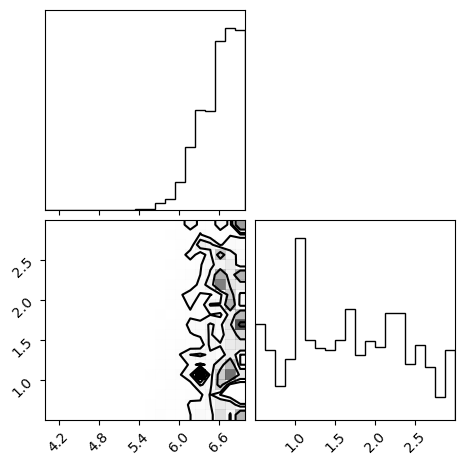

In [11]:
prior_weights1 = 1./(1.+auxSamps1['redshift'])**2/auxSamps1["luminosity_distance"]**2/ddLdz(auxSamps1['redshift'])
simulation_weights1 = 3.645/(auxSamps1['rh']-0.3)
total_weights1 = Mcl_rh_weights1*prior_weights1*efficiency_weights1
fig = corner.corner(np.transpose([auxSamps1['logMcl'], auxSamps1['rh']]), weights = total_weights1, plot_datapoints=False)
fig.show()

Now, repeat for all other events and save the likelihood samples and weights.

In [14]:
events = np.loadtxt("./GWTC3-posteriors/events.txt", dtype="str")
for (i, event) in enumerate(events):
    try:
        auxSamps = create_auxillary_samples(event)
        points = jnp.vstack([auxSamps['logMcl'], auxSamps['rh'], auxSamps['mass_1_source'], auxSamps['mass_2_source'], auxSamps['redshift'], auxSamps['chi_eff']])
        logMcl_rh_weights = get_pdf_Mcl_rh(points)
        PEprior_weights = 1./(1.+auxSamps['redshift'])**2/auxSamps["luminosity_distance"]**2/ddLdz(auxSamps['redshift'])
        efficiency_weights = 1./get_efficiency_weight(auxSamps)
        simulation_weights = 3.645/(auxSamps['rh']-0.3)
        name = event[16:31]
        cat = h5.File("./Mcl_rh_posterior/"+name+".h5", 'w')
        cat.create_dataset(name="logMcl_rh_weights", data=logMcl_rh_weights)
        cat.create_dataset(name="simulation_weights", data=simulation_weights)
        cat.create_dataset(name="PEprior_weights", data=PEprior_weights)
        cat.create_dataset(name="points", data=auxSamps)
        cat.create_dataset(name="efficiency_weights", data=efficiency_weights)
        cat.close()
        ### check corner plots if needed.
        # total_weights = logMcl_rh_weights*PEprior_weights*simulation_weights
        # fig = corner.corner(np.transpose([auxSamps['logMcl'], auxSamps['rh']]), weights = total_weights, plot_datapoints=False)
        # fig.suptitle(name)
        # fig.show()
    except KeyError:
        continue

Now make some quick plots for all events.
As usual, let's take a look of 95% intervals.

In [12]:
import matplotlib.colors as colors
import matplotlib.cm as cm
norm = colors.Normalize(vmin=0, vmax=1, clip=True)
mapper = cm.ScalarMappable(norm=norm)
from latex import *

In [13]:
def HPD_interval(data,mass=0.9):
    Data=np.sort(data)
    nsamp=Data.shape[0]
    length=int(mass*nsamp)
    starts=Data[:nsamp-length+1]
    ends=Data[length-1:]
    intervals=ends-starts
    min_idx=np.argmin(intervals)
    return starts[min_idx], np.median(Data), ends[min_idx]

In [14]:
def get_stats_1d(samples, weights, size=1000):
    samples_re = np.random.choice(samples, p=weights, size = size, replace=True)
    lower, median, upper = HPD_interval(samples_re)
    return lower, median, upper

In [15]:
log10Mcllabel = r"$\log_{10}(M_{\mathrm{cl}}/M_{\odot})$"
m1label = r"$m_1~(M_{\odot})$"
rhlabel = r"$r_h~(\mathrm{pc})$"

Plot $M_{\rm cl}$ vs $m_1$.
If there are too few effective samples $(<100)$, we refine the samples by repeating the above sampling process with different sets of uniformly drawn $\lambda^{\rm cl}$.

/tmp/ipykernel_2538/3995718523.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


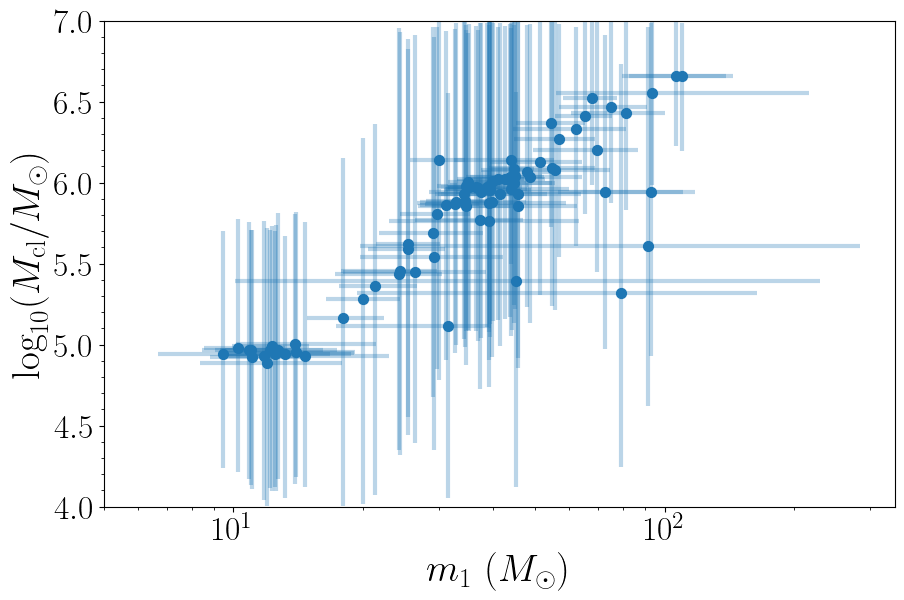

In [16]:
event_names = np.loadtxt("./GWTC3-posteriors/event_names_BBH.txt", dtype="str")
fig, ax = plt.subplots(1,1)
for (i, name) in enumerate(event_names):
    try:
        #name = event[16:31]
        cat = h5.File("./Mcl_rh_posterior/"+name+".h5", 'r')
        logMcl_rh_weights = cat["logMcl_rh_weights"][()]
        PEprior_weights = cat["PEprior_weights"][()]
        efficiency_weights = cat["efficiency_weights"][()]
        points = cat["points"][()]
        logMcl_samples, rh_samples = points["logMcl"], points["rh"]
        total_weights = logMcl_rh_weights*PEprior_weights*efficiency_weights
        total_weights /= np.sum(total_weights)
        logMcl_pos_lower, logMcl_pos_median, logMcl_pos_upper = get_stats_1d(logMcl_samples, total_weights, size=10000)
        cbc_pos_samples_raw = np.maximum(points["mass_1_source"], points["mass_2_source"])
        PEprior_weights /= np.sum(PEprior_weights)
        cbc_pos_lower, cbc_pos_median, cbc_pos_upper = get_stats_1d(cbc_pos_samples_raw, PEprior_weights, size=10000)
        sc = ax.scatter(cbc_pos_median, logMcl_pos_median, c="C0", s = 50)
        ax.errorbar(cbc_pos_median, logMcl_pos_median, \
            yerr=[[logMcl_pos_median - logMcl_pos_lower], [logMcl_pos_upper- logMcl_pos_median]], \
            xerr=[[cbc_pos_median - cbc_pos_lower], [cbc_pos_upper- cbc_pos_median]], c="C0", alpha=0.3)
        neff = np.sum(total_weights)**2/np.sum(total_weights**2)
        if neff < 100:
            print(name, neff)
            fig_corner = corner.corner(np.transpose([logMcl_samples, rh_samples]), weights = total_weights, plot_datapoints=False)
            fig_corner.suptitle(name)
            fig_corner.show()
        cat.close()
    except FileNotFoundError:
        continue
ax.set_xscale('log')
ax.set_xlabel(m1label)
ax.set_ylabel(log10Mcllabel)
ax.set_ylim(4, 7)
ax.set_xlim(left=5)
fig.show()
fig.savefig("Mcl_m1_CI90_all.pdf")

Plot $M_{\rm cl}$ vs $q$.

/tmp/ipykernel_2538/2018314943.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


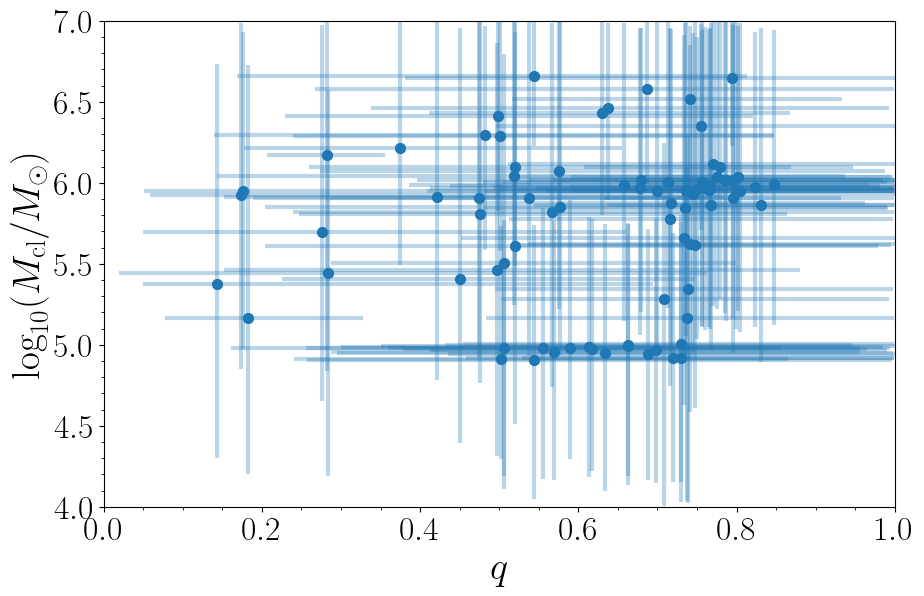

In [17]:
event_names = np.loadtxt("./GWTC3-posteriors/event_names_BBH.txt", dtype="str")
fig, ax = plt.subplots(1,1)
for (i, name) in enumerate(event_names):
    try:
        #name = event[16:31]
        cat = h5.File("./Mcl_rh_posterior/"+name+".h5", 'r')
        logMcl_rh_weights = cat["logMcl_rh_weights"][()]
        PEprior_weights = cat["PEprior_weights"][()]
        efficiency_weights = cat["efficiency_weights"][()]
        total_weights = logMcl_rh_weights*PEprior_weights*efficiency_weights
        total_weights /= np.sum(total_weights)
        points = cat["points"][()]
        logMcl_samples, rh_samples = points["logMcl"], points["rh"]
        logMcl_pos_samples = np.random.choice(logMcl_samples, p=total_weights, size = 1000, replace=True)
        logMcl_pos_lower, logMcl_pos_median, logMcl_pos_upper = HPD_interval(logMcl_pos_samples)
        cbc_pos_samples_raw = np.minimum(points["mass_1_source"]/points["mass_2_source"], points["mass_2_source"]/points["mass_1_source"])
        PEprior_weights /= np.sum(PEprior_weights)
        cbc_pos_samples = np.random.choice(cbc_pos_samples_raw, p=PEprior_weights, size = 1000)
        cbc_pos_lower, cbc_pos_median, cbc_pos_upper = HPD_interval(cbc_pos_samples)
        sc = ax.scatter(cbc_pos_median, logMcl_pos_median, c="C0", s = 50)
        ax.errorbar(cbc_pos_median, logMcl_pos_median, \
            yerr=[[logMcl_pos_median - logMcl_pos_lower], [logMcl_pos_upper- logMcl_pos_median]], \
            xerr=[[cbc_pos_median - cbc_pos_lower], [cbc_pos_upper- cbc_pos_median]], c="C0", alpha=0.3)
        neff = np.sum(total_weights)**2/np.sum(total_weights**2)
        if neff < 100:
            print(name, neff)
            fig_corner = corner.corner(np.transpose([logMcl_samples, rh_samples]), weights = total_weights, plot_datapoints=False)
            fig_corner.suptitle(name)
            fig_corner.show()
        cat.close()
    except FileNotFoundError:
        continue
ax.set_xlabel(r"$q$")
ax.set_ylabel(log10Mcllabel)
ax.set_ylim(4, 7)
ax.set_xlim(0, 1)
#fig.colorbar(sc)
fig.show()
fig.savefig("Mcl_q_CI90_all.pdf")

Plot $r_h$ vs $m_1$.

/tmp/ipykernel_2538/1081436822.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


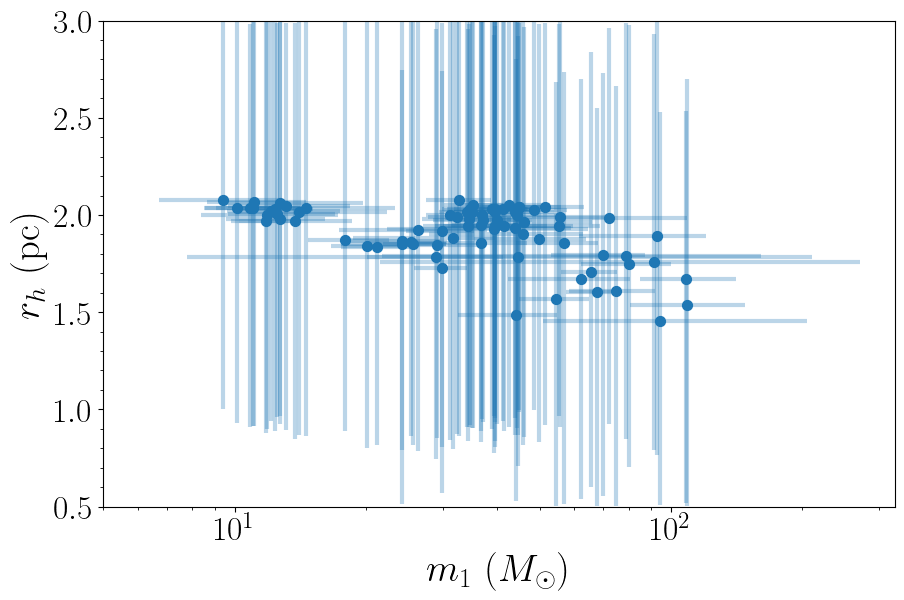

In [18]:
event_names = np.loadtxt("./GWTC3-posteriors/event_names_BBH.txt", dtype="str")
fig, ax = plt.subplots(1,1)
for (i, name) in enumerate(event_names):
    try:
        #name = event[16:31]
        cat = h5.File("./Mcl_rh_posterior/"+name+".h5", 'r')
        logMcl_rh_weights = cat["logMcl_rh_weights"][()]
        PEprior_weights = cat["PEprior_weights"][()]
        efficiency_weights = cat["efficiency_weights"][()]
        total_weights = logMcl_rh_weights*PEprior_weights*efficiency_weights
        total_weights /= np.sum(total_weights)
        points = cat["points"][()]
        logMcl_samples, rh_samples = points["logMcl"], points["rh"]
        rh_pos_samples = np.random.choice(rh_samples, p=total_weights, size = 1000, replace=True)
        rh_pos_lower, rh_pos_median, rh_pos_upper = HPD_interval(rh_pos_samples)
        cbc_pos_samples_raw = np.maximum(points["mass_1_source"], points["mass_2_source"])
        PEprior_weights /= np.sum(PEprior_weights)
        cbc_pos_samples = np.random.choice(cbc_pos_samples_raw, p=PEprior_weights, size = 1000)
        cbc_pos_lower, cbc_pos_median, cbc_pos_upper = HPD_interval(cbc_pos_samples)
        ax.scatter(cbc_pos_median, rh_pos_median, c="C0", s=50)
        ax.errorbar(cbc_pos_median, rh_pos_median, \
            yerr=[[rh_pos_median - rh_pos_lower], [rh_pos_upper- rh_pos_median]], \
            xerr=[[cbc_pos_median - cbc_pos_lower], [cbc_pos_upper- cbc_pos_median]], color='C0', alpha=0.3)
        # fig = corner.corner(np.transpose([logMcl_samples, rh_samples]), weights = total_weights, plot_datapoints=False)
        # fig.suptitle(name)
        # fig.show()
        cat.close()
    except FileNotFoundError:
        continue
ax.set_xscale('log')
ax.set_xlabel(m1label)
ax.set_ylabel(rhlabel)
ax.set_ylim(0.5, 3)
ax.set_xlim(left=5)
fig.show()
fig.savefig("rh_m1_CI90_all.pdf")

Refining low Neff samples. Automation of the refinement to be done.

In [ ]:
trials = 100
auxSamps6_all, Mcl_rh_weights6_all, efficiency_weights6_all = np.array([], dtype=auxSamps6.dtype), [], []
for i in range(trials):
    auxSamps6 = create_auxillary_samples("IGWN-GWTC2p1-v2-GW190403_051519_PEDataRelease_mixed_nocosmo.h5")
    points6 = jnp.vstack([auxSamps6['logMcl'], auxSamps6['rh'], auxSamps6['mass_1_source'], auxSamps6['mass_2_source'], auxSamps6['redshift'], auxSamps6['chi_eff']])
    Mcl_rh_weights6 = get_pdf_Mcl_rh(points6)
    efficiency_weights6 = 1./get_efficiency_weight(auxSamps6)
    auxSamps6_all = np.append(auxSamps6, auxSamps6_all)
    Mcl_rh_weights6_all = np.append(Mcl_rh_weights6, Mcl_rh_weights6_all)
    efficiency_weights6_all = np.append(efficiency_weights6, efficiency_weights6_all)

In [ ]:
prior_weights6_all = 1./(1.+auxSamps6_all['redshift'])**2/auxSamps6_all["luminosity_distance"]**2/ddLdz(auxSamps6_all['redshift'])
total_weights6_all = Mcl_rh_weights6_all*efficiency_weights6_all*prior_weights6_all

In [ ]:
cat = h5.File("./Mcl_rh_posterior/GW190403_051519.h5", 'w')
cat.create_dataset(name="logMcl_rh_weights", data=Mcl_rh_weights6_all)
cat.create_dataset(name="simulation_weights", data=3.645/(auxSamps6_all['rh']-0.3))
cat.create_dataset(name="PEprior_weights", data=prior_weights6_all)
cat.create_dataset(name="points", data=auxSamps6_all)
cat.create_dataset(name="efficiency_weights", data=efficiency_weights6_all)
cat.close()

/tmp/ipykernel_5573/968837520.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


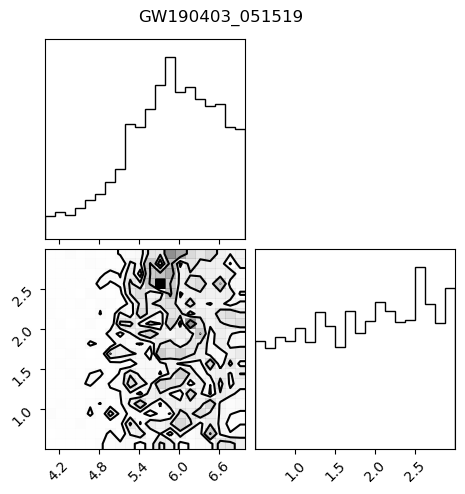

In [ ]:
fig = corner.corner(np.transpose([auxSamps6_all['logMcl'], auxSamps6_all['rh']]), weights = total_weights6_all, plot_datapoints=False)
fig.suptitle("GW190403_051519")
fig.show()